In [10]:
import torch._dynamo as dynamo
dynamo.disable()

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

batch_size = 128
lr = 0.01
epochs = 20
ssd_lambda = 1e-4
forget_classes = [0, 1]

paths = {
    "baseline":    "10res18_baseline.pth",
    "pre_unlearn": "10res18_preunlearn.pth",
    "retrain":     "10res18_retrain.pth",
    "ssd":         "10res18_ssd.pth",
    "teacher":     "10res18_teacher.pth",
    "deepclean":   "10res18_deepclean.pth",
    "salun":       "10res18_salun.pth",
}


In [2]:
transform = transforms.Compose([
    transforms.RandomCrop(32, 4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.247, 0.243, 0.261)),
])
train_full = datasets.CIFAR10("./data", train=True, download=True, transform=transform)
test_full = datasets.CIFAR10("./data", train=False, download=True, transform=transform)

np.random.seed(0)
idx_train = np.random.permutation(len(train_full))
idx_test = np.random.permutation(len(test_full))
train_ds = Subset(train_full, idx_train)
test_ds = Subset(test_full, idx_test)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

labels = np.array([train_full[i][1] for i in idx_train])
mask_f = np.isin(labels, forget_classes)
forget_loader = DataLoader(Subset(train_ds, np.where(mask_f)[0]),
                           batch_size=batch_size, shuffle=True, num_workers=2)
retain_loader = DataLoader(Subset(train_ds, np.where(~mask_f)[0]),
                           batch_size=batch_size, shuffle=True, num_workers=2)

def get_model():
    m = models.resnet18(pretrained=False, num_classes=10)
    return m.to(device)

criterion = nn.CrossEntropyLoss()

def train_one(model, loader, opt):
    model.train()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        opt.step()

def evaluate(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100 * correct / total

model = get_model()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
for epoch in range(epochs):
    train_one(model, train_loader, opt)
    print(f"Epoch {epoch+1}/{epochs} done.")
print("Baseline acc:", evaluate(model, test_loader))
torch.save(model.state_dict(), paths["baseline"])
torch.save(model.state_dict(), paths["pre_unlearn"])



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/20 done.
Epoch 2/20 done.
Epoch 3/20 done.
Epoch 4/20 done.
Epoch 5/20 done.
Epoch 6/20 done.
Epoch 7/20 done.
Epoch 8/20 done.
Epoch 9/20 done.
Epoch 10/20 done.
Epoch 11/20 done.
Epoch 12/20 done.
Epoch 13/20 done.
Epoch 14/20 done.
Epoch 15/20 done.
Epoch 16/20 done.
Epoch 17/20 done.
Epoch 18/20 done.
Epoch 19/20 done.
Epoch 20/20 done.
Baseline acc: 74.77


In [3]:

# 5. SSD Unlearning
fisher = {n: torch.zeros_like(p) for n, p in model.named_parameters() if p.requires_grad}
model.eval()
count = 0
for x, y in forget_loader:
    x, y = x.to(device), y.to(device)
    model.zero_grad()
    loss = criterion(model(x), y)
    loss.backward()
    for n, p in model.named_parameters():
        if p.requires_grad and p.grad is not None:
            fisher[n] += p.grad.data.pow(2)
    count += 1
for n in fisher:
    fisher[n] /= count

with torch.no_grad():
    for n, p in model.named_parameters():
        if p.requires_grad:
            p.sub_(ssd_lambda * fisher[n] * p)

# Fine-tune on retain
opt2 = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
for _ in range(3):
    train_one(model, retain_loader, opt2)
print("SSD acc:", evaluate(model, test_loader))
torch.save(model.state_dict(), paths["ssd"])


SSD acc: 62.89


In [4]:

# 6. Incompetent Teacher Unlearning
teacher = get_model()
teacher.load_state_dict(torch.load(paths["pre_unlearn"], map_location=device))
teacher.eval()

student = get_model()
opt_s = optim.SGD(student.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

def distill_loss(s_out, t_out, T=3.0, alpha=0.7):
    soft = nn.functional.log_softmax(s_out / T, dim=1)
    target = nn.functional.softmax(t_out / T, dim=1)
    hard = target.argmax(dim=1)
    return nn.KLDivLoss()(soft, target) * (T * T) * alpha + criterion(s_out, hard) * (1 - alpha)

for epoch in range(epochs):
    student.train()
    for x, y in retain_loader:
        x = x.to(device)
        opt_s.zero_grad()
        s_out, t_out = student(x), teacher(x)
        loss = distill_loss(s_out, t_out)
        loss.backward()
        opt_s.step()

print("Teacher-Student acc:", evaluate(student, test_loader))
torch.save(student.state_dict(), paths["teacher"])

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Teacher-Student acc: 64.91


In [5]:

# 9. Improved DeepClean Unlearning
model_dc = get_model(); model_dc.load_state_dict(torch.load(paths["pre_unlearn"]))
f_f = {n: torch.zeros_like(p) for n, p in model_dc.named_parameters() if p.requires_grad}
f_r = {n: torch.zeros_like(p) for n, p in model_dc.named_parameters() if p.requires_grad}

for loader, fmap in [(forget_loader, f_f), (retain_loader, f_r)]:
    count = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        model_dc.zero_grad()
        criterion(model_dc(x), y).backward()
        for n, p in model_dc.named_parameters():
            if p.grad is not None:
                fmap[n] += p.grad.data.pow(2)
        count += 1
    for n in fmap:
        fmap[n] /= max(count, 1)

with torch.no_grad():
    for n, p in model_dc.named_parameters():
        if p.requires_grad:
            sens = (f_f[n] + 1e-8) / (f_r[n] + 1e-8)
            threshold = sens.flatten().quantile(0.75)  # changed from 0.9 → 0.75 for more unlearning
            mask = sens > threshold
            p[mask] = torch.randn_like(p[mask]) * 0.01

opt_dc = optim.SGD(model_dc.parameters(), lr=lr, momentum=0.9)
for _ in range(3):
    train_one(model_dc, retain_loader, opt_dc)

print("Improved DeepClean acc:", evaluate(model_dc, test_loader))
torch.save(model_dc.state_dict(), paths["deepclean"])


Improved DeepClean acc: 60.3


In [6]:

# 10. Improved SalUn Unlearning
model_su = get_model(); model_su.load_state_dict(torch.load(paths["pre_unlearn"]))
sal = {n: 0.0 for n, _ in model_su.named_parameters() if _.requires_grad}

for x, y in forget_loader:
    x, y = x.to(device), y.to(device)
    model_su.zero_grad()
    out = model_su(x)
    loss = criterion(out, y)
    loss.backward()
    for n, p in model_su.named_parameters():
        if p.grad is not None:
            sal[n] += p.grad.data.abs().sum().item()

vals = torch.tensor(list(sal.values()))
threshold = vals.quantile(0.4)  # previously 0.5; fine-tune more weights
for n, p in model_su.named_parameters():
    if sal[n] < threshold:
        p.requires_grad = False

opt_su = optim.Adam(filter(lambda p: p.requires_grad, model_su.parameters()), lr=lr)
for _ in range(8):  # increased fine-tune epochs
    for x, y in retain_loader:
        x, y = x.to(device), y.to(device)
        opt_su.zero_grad()
        out = model_su(x)
        loss = criterion(out, y)
        loss.backward()
        opt_su.step()

print("Improved SalUn acc:", evaluate(model_su, test_loader))
torch.save(model_su.state_dict(), paths["salun"])


Improved SalUn acc: 57.5


In [11]:
model_retrain = get_model()
model_retrain.load_state_dict(torch.load(paths["pre_unlearn"], map_location=device))
optimizer_retrain = optim.SGD(model_retrain.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
for epoch in range(epochs):
    train_one(model_retrain, retain_loader, optimizer_retrain)
    acc = evaluate(model_retrain, test_loader)
    print(f"[Retrain] Epoch {epoch+1}/{epochs} — Test Acc: {acc:.2f}%")
torch.save(model_retrain.state_dict(), paths["retrain"])

[Retrain] Epoch 1/20 — Test Acc: 63.57%
[Retrain] Epoch 2/20 — Test Acc: 62.95%
[Retrain] Epoch 3/20 — Test Acc: 62.83%
[Retrain] Epoch 4/20 — Test Acc: 63.03%
[Retrain] Epoch 5/20 — Test Acc: 63.18%
[Retrain] Epoch 6/20 — Test Acc: 64.11%
[Retrain] Epoch 7/20 — Test Acc: 63.52%
[Retrain] Epoch 8/20 — Test Acc: 63.57%
[Retrain] Epoch 9/20 — Test Acc: 64.45%
[Retrain] Epoch 10/20 — Test Acc: 63.82%
[Retrain] Epoch 11/20 — Test Acc: 63.82%
[Retrain] Epoch 12/20 — Test Acc: 64.98%
[Retrain] Epoch 13/20 — Test Acc: 63.77%
[Retrain] Epoch 14/20 — Test Acc: 64.68%
[Retrain] Epoch 15/20 — Test Acc: 65.03%
[Retrain] Epoch 16/20 — Test Acc: 64.90%
[Retrain] Epoch 17/20 — Test Acc: 64.84%
[Retrain] Epoch 18/20 — Test Acc: 63.05%
[Retrain] Epoch 19/20 — Test Acc: 64.85%
[Retrain] Epoch 20/20 — Test Acc: 64.20%


In [7]:
# 11. Per-Class Evaluation

import torch
import pandas as pd

model_names = ["baseline", "ssd","teacher", "deepclean", "salun", "retrain"]

columns = ["Model"] + [f"Class_{i}" for i in range(10)]
results = []

def per_class_correct(model, loader):
    model.eval()
    correct = torch.zeros(10, dtype=torch.int64)
    total   = torch.zeros(10, dtype=torch.int64)
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            for cls in range(10):
                mask = (y == cls)
                total[cls]   += mask.sum().item()
                correct[cls] += (preds[mask] == cls).sum().item()
    return correct, total

for name in model_names:

    m = get_model()
    m.load_state_dict(torch.load(paths[name], map_location=device))

    correct, total = per_class_correct(m, test_loader)

    row = [f"{correct[i].item()}/{total[i].item()}" for i in range(10)]
    results.append([name] + row)

df = pd.DataFrame(results, columns=columns)
print(df.to_string(index=False))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


    Model  Class_0  Class_1  Class_2  Class_3  Class_4  Class_5  Class_6  Class_7  Class_8  Class_9
 baseline 790/1000 887/1000 672/1000 582/1000 775/1000 529/1000 852/1000 712/1000 896/1000 835/1000
      ssd   0/1000   0/1000 773/1000 743/1000 767/1000 549/1000 776/1000 850/1000 906/1000 936/1000
  teacher 432/1000 337/1000 742/1000 518/1000 738/1000 505/1000 830/1000 694/1000 913/1000 846/1000
deepclean   0/1000   0/1000 719/1000 568/1000 653/1000 749/1000 824/1000 719/1000 860/1000 951/1000
    salun   0/1000   0/1000 739/1000 592/1000 668/1000 549/1000 658/1000 864/1000 918/1000 799/1000


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


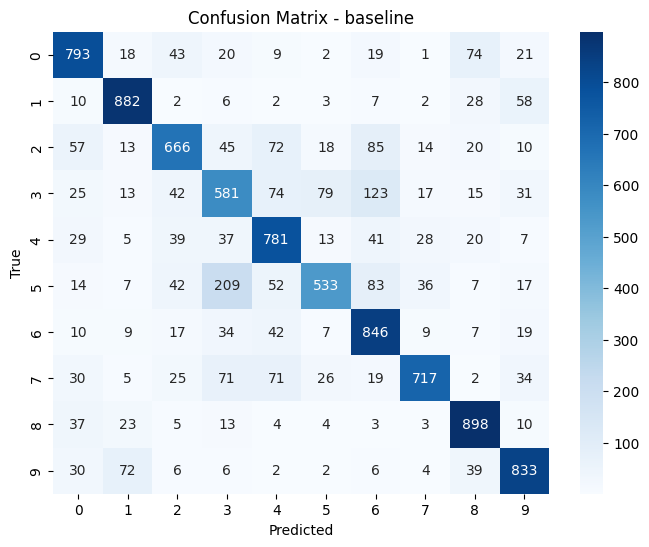

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


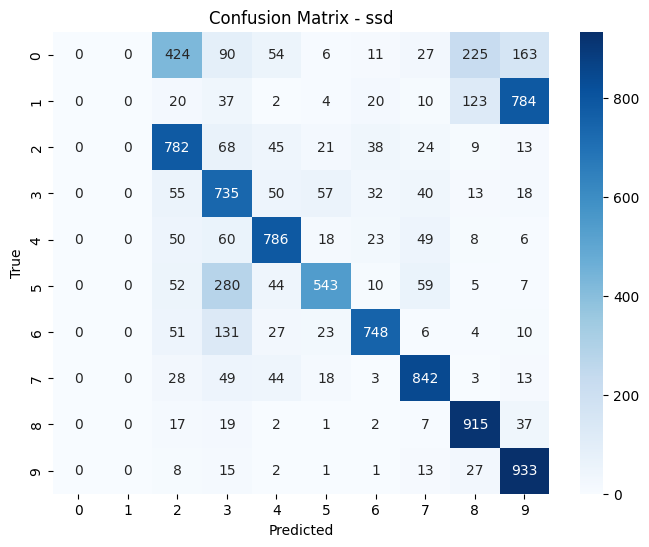

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


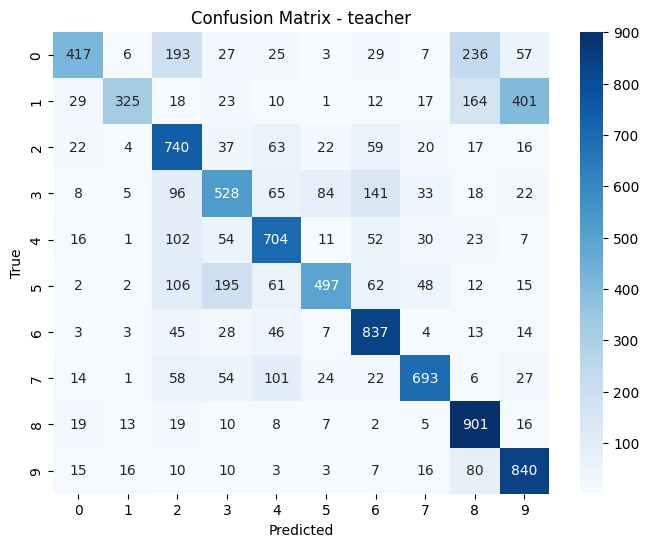

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


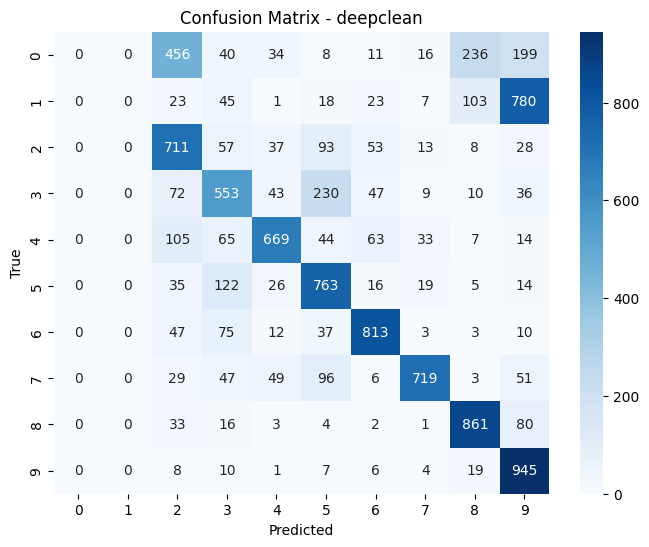

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


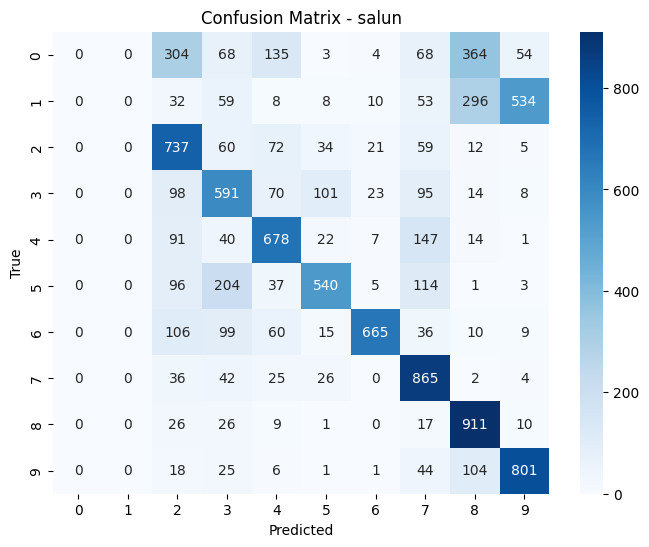

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


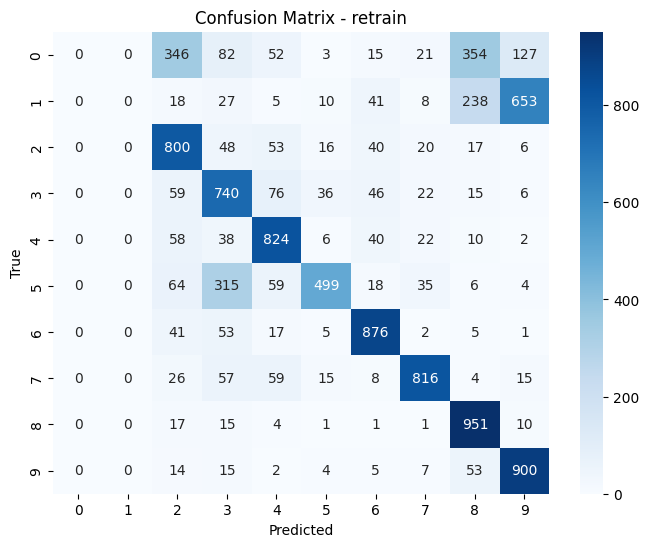

Per-Class Accuracy Summary:
    Model  Class_0  Class_1  Class_2  Class_3  Class_4  Class_5  Class_6  Class_7  Class_8  Class_9
 baseline 793/1000 882/1000 666/1000 581/1000 781/1000 533/1000 846/1000 717/1000 898/1000 833/1000
      ssd   0/1000   0/1000 782/1000 735/1000 786/1000 543/1000 748/1000 842/1000 915/1000 933/1000
  teacher 417/1000 325/1000 740/1000 528/1000 704/1000 497/1000 837/1000 693/1000 901/1000 840/1000
deepclean   0/1000   0/1000 711/1000 553/1000 669/1000 763/1000 813/1000 719/1000 861/1000 945/1000
    salun   0/1000   0/1000 737/1000 591/1000 678/1000 540/1000 665/1000 865/1000 911/1000 801/1000
  retrain   0/1000   0/1000 800/1000 740/1000 824/1000 499/1000 876/1000 816/1000 951/1000 900/1000


In [12]:
# 10. Per-Class Evaluation & Confusion Matrices
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model_names = ["baseline", "ssd", "teacher",  "deepclean", "salun", "retrain"]
columns = ["Model"] + [f"Class_{i}" for i in range(10)]
results = []

for name in model_names:

    m = get_model()
    m.load_state_dict(torch.load(paths[name], map_location=device))


    m_correct = torch.zeros(10, dtype=torch.int64)
    m_total   = torch.zeros(10, dtype=torch.int64)
    all_preds, all_labels = [], []

    m.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            preds = m(x).argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            for cls in range(10):
                mask = (y == cls)
                m_total[cls]   += mask.sum().item()
                m_correct[cls] += (preds[mask] == cls).sum().item()


    row = [name] + [f"{m_correct[i].item()}/{m_total[i].item()}" for i in range(10)]
    results.append(row)


    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[str(i) for i in range(10)],
                yticklabels=[str(i) for i in range(10)])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()


df = pd.DataFrame(results, columns=columns)
print("Per-Class Accuracy Summary:")
print(df.to_string(index=False))